# Preprocessing RADARSAT-2 ScanSAR Wide images to Analysis Ready Data for a Convolutional Neural Network

This code is only an example on a single image to show all the different steps of the preprocessing and visualize the output image. The code rs2_ARD_process.py is the same code that can be ran from the command line and can process five images simultaneously. The zip files of the images must all be saved under the "data" subfolder. The code will find all RS2 images from that subfolder and process them.

# Visualizing the uncalibrate RS2 image

Library imports needed

In [1]:
import subprocess, gdal, zipfile, shutil, os
from os.path import join
import numpy as np
import xml.etree.ElementTree as ET
import scipy
from scipy import signal
from matplotlib import pyplot as plt

Subfolder where the imagery is stored and the filename

In [2]:
zippath = r'Data'
img = 'RS2_OK9968_PK112693_DK109010_SCWA_20100213_004158_HH_HV_SGF.zip'

Unzipping the image product

In [3]:
im_zip = zipfile.ZipFile(os.path.join(zippath, img))
im_zip.extractall(zippath)
im_zip.close

<bound method ZipFile.close of <zipfile.ZipFile filename='Data\\RS2_OK9968_PK112693_DK109010_SCWA_20100213_004158_HH_HV_SGF.zip' mode='r'>>

Using GDAL to read the RS2 image, the number of pixels in x/y and the HH/HV image bands

In [4]:
# Reads the RS2 image product with all of the georeferenced information
ras = gdal.Open(join(zippath, img.strip('.zip'),'product.xml'))

# Number of pixels in range
x = ras.RasterXSize

# Number of pixels in azimuth
y = ras.RasterYSize

# Read the HH band and stores it in a Numpy array
hh = np.float32(ras.GetRasterBand(1).ReadAsArray())

# Read the HV band and stores it in a Numpy array
hv = np.float32(ras.GetRasterBand(2).ReadAsArray())

Displays the 8-bit Digital Number values of both bands

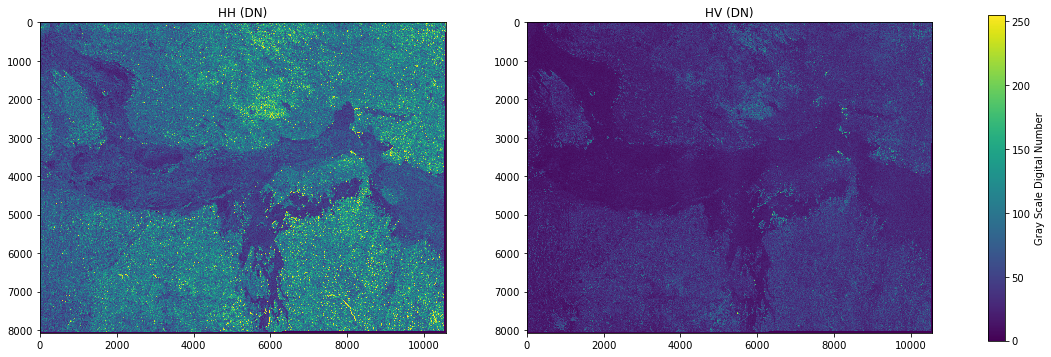

In [5]:
fig, ax = plt.subplots(1,2,figsize=(20,10))

hh_plot = ax[0].imshow(hh)
ax[0].set_title('HH (DN)')
hv_plot = ax[1].imshow(hv)
ax[1].set_title('HV (DN)')
cbar = fig.colorbar(hh_plot, ax=ax.ravel().tolist(), shrink=0.6)
cbar.set_label('Gray Scale Digital Number')

Read the Look Up Table information xml file to calibrate the image into sigma-nought

In [6]:
tree = ET.parse(join(zippath, img.strip('.zip'),'lutSigma.xml'))
root = tree.getroot()
gains = np.float32(np.array(root.find('gains').text.split(' ')))

Read the RS2 image product metadata file to extract the incidence angle and Noise Equivalent Sigma Zero (NESZ) information

In [7]:
tree = ET.parse(join(zippath, img.strip('.zip'),'product.xml'))
root = tree.getroot()
pref = root.tag.strip('product')
nearang = np.float32(root.find(pref + 'imageGenerationParameters').find(pref + 'sarProcessingInformation').find(pref + 'incidenceAngleNearRange').text)
farang = np.float32(root.find(pref + 'imageGenerationParameters').find(pref + 'sarProcessingInformation').find(pref + 'incidenceAngleFarRange').text)
look = root.find(pref + 'sourceAttributes').find(pref + 'orbitAndAttitude').find(pref + 'orbitInformation').find(pref + 'passDirection').text

for lut in root.iter(pref + 'referenceNoiseLevel'):

    if lut.attrib['incidenceAngleCorrection'] == 'Sigma Nought':

        steps = int(lut.findall('{http://www.rsi.ca/rs2/prod/xml/schemas}stepSize')[0].text)
        first_value = int(lut.findall('{http://www.rsi.ca/rs2/prod/xml/schemas}pixelFirstNoiseValue')[0].text)
        noise = np.array(lut.findall('{http://www.rsi.ca/rs2/prod/xml/schemas}noiseLevelValues')[0].text.split(' '),np.float32)

gains_temp = np.zeros(x, np.float32)
gains_temp[first_value::steps] = np.power(10, noise/10)
kernel = signal.triang(2*steps - 1)
noisepat = 10 * np.log10(scipy.ndimage.filters.convolve(gains_temp, kernel, mode="constant"))

#Set the incidence angle in the right order
if look == 'Ascending':

    incang = np.interp(np.arange(x),[0,len(np.arange(x))-1],[nearang,farang])

else:

    incang = np.interp(np.arange(x),[0,len(np.arange(x))-1],[farang,nearang])

Plots the incidence angle and NESZ information in the range direction

Text(0, 0.5, 'NESZ (dB)')

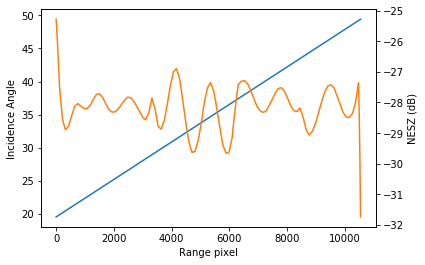

In [8]:
fig, ax1 = plt.subplots()

ax1.plot(incang)
ax1.set_ylabel('Incidence Angle')
ax1.set_xlabel('Range pixel')

ax2 = ax1.twinx()
ax2.plot(noisepat,'C1')
ax2.set_ylabel('NESZ (dB)')

Initiate the incidence angle and NESZ arrays to include in the imagery

In [9]:
incangs = np.zeros([y,x], dtype = np.float32)
noiseimg = np.zeros([y,x], dtype = np.float32)

Calibrate the HH/HV bands into sigma-nought and populates the incidence angles and NESZ images (constants in azimuth)

In [10]:
for i in np.arange(y):

    hh[i,] = np.true_divide(hh[i,]**2, gains)
    hv[i,] = np.true_divide(hv[i,]**2, gains)
    incangs[i,] = incang
    noiseimg[i,] = noisepat

Display the calibrated HH/Hv bands in linear units and the incidence angles and NESZ bands

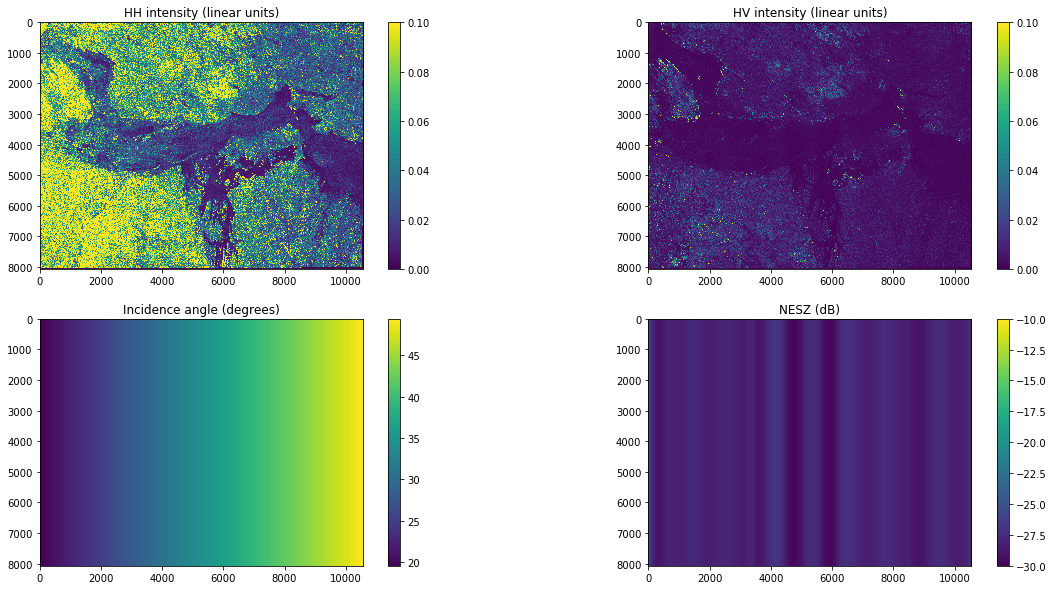

In [11]:
fig, ax = plt.subplots(2,2,figsize=(20,10))

hh_plot = ax[0,0].imshow(hh, vmin=0, vmax=0.1)
ax[0,0].set_title('HH intensity (linear units)')
fig.colorbar(hh_plot, ax=ax[0,0])
hv_plot = ax[0,1].imshow(hv, vmin=0, vmax=0.1)
ax[0,1].set_title('HV intensity (linear units)')
fig.colorbar(hv_plot, ax=ax[0,1])
ang_plot = ax[1,0].imshow(incangs)
ax[1,0].set_title('Incidence angle (degrees)')
fig.colorbar(ang_plot, ax=ax[1,0])
noise_plot = ax[1,1].imshow(noiseimg, vmin=-30, vmax=-10)
ax[1,1].set_title('NESZ (dB)')
fig.colorbar(noise_plot, ax=ax[1,1])

Convert the linear units into decibels (zero values are changes to 1e-9 since log(0)=inf)

In [12]:
hh[hh<=0] = 1E-9    
hv[hv<=0] = 1E-9

In [13]:
hh = 10*np.log10(hh)
hv = 10*np.log10(hv)

Same as previous figure but in decibels for HH/HV

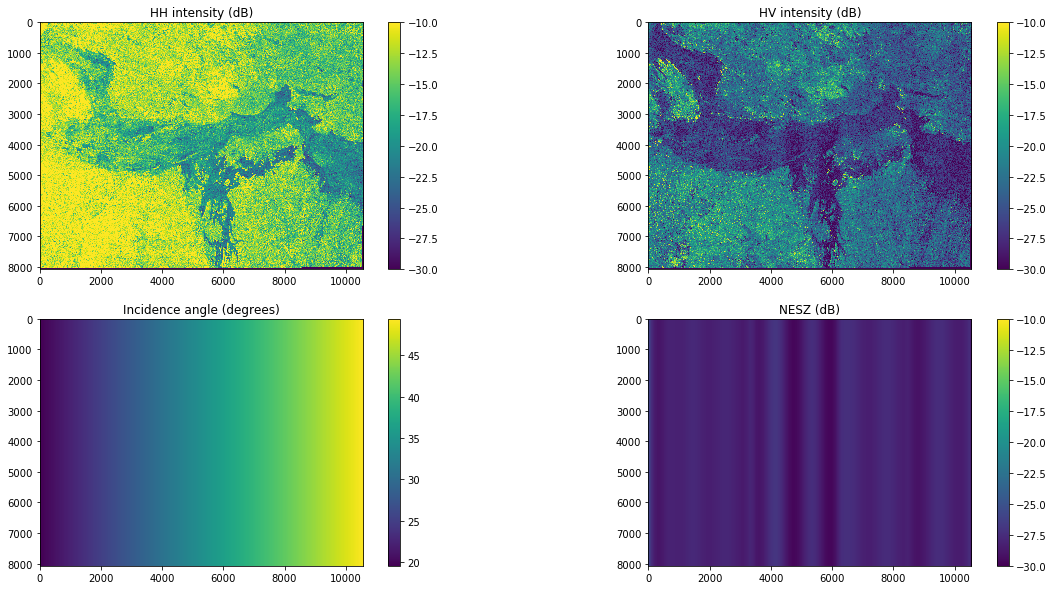

In [14]:
fig, ax = plt.subplots(2,2,figsize=(20,10))

hh_plot = ax[0,0].imshow(hh, vmin=-30, vmax=-10)
ax[0,0].set_title('HH intensity (dB)')
fig.colorbar(hh_plot, ax=ax[0,0])
hv_plot = ax[0,1].imshow(hv, vmin=-30, vmax=-10)
ax[0,1].set_title('HV intensity (dB)')
fig.colorbar(hv_plot, ax=ax[0,1])
ang_plot = ax[1,0].imshow(incangs)
ax[1,0].set_title('Incidence angle (degrees)')
fig.colorbar(ang_plot, ax=ax[1,0])
noise_plot = ax[1,1].imshow(noiseimg, vmin=-30, vmax=-10)
ax[1,1].set_title('NESZ (dB)')
fig.colorbar(noise_plot, ax=ax[1,1])

# Creation of the calibrated image with the 4 bands as a georeferenced tiff

Initialization of the image

In [15]:
outfile2 = 'calib_' + img.strip('.zip') + '.tif'
driver = gdal.GetDriverByName('GTiff')
driver.Register()
#Create the image with the GTiff driver, with the same x/y dimension as the initial image, with 4 float32 bands
outDataset = driver.Create(outfile2, x, y, 4, gdal.GDT_Float32)

Copies the georeference information of the initial image to the new image

In [16]:
geoTransform = ras.GetGeoTransform()
outDataset.SetGeoTransform(geoTransform)
gcps = ras.GetGCPs()
gcpproj = ras.GetGCPProjection()
proj = ras.GetProjection()
outDataset.SetProjection(proj)
outDataset.SetGCPs(gcps, gcpproj)

0

Saves the four bands into the new image

In [17]:
outhh = outDataset.GetRasterBand(1)
outhh.WriteArray(hh, 0, 0)

#Write HV band
outhv = outDataset.GetRasterBand(2)
outhv.WriteArray(hv, 0, 0)

#Write incidence angle band
outang = outDataset.GetRasterBand(3)
outang.WriteArray(incangs, 0, 0)

#Write incidence angle band
outnoise = outDataset.GetRasterBand(4)
outnoise.WriteArray(noiseimg, 0, 0)

0

Clears all the new image information 

**NOTE: this is required in order for the image to be saved and usuable outside this python environment

In [18]:
outhh = None
outhv = None
outang = None
outnoise = None
outDataset = None
driver = None
proj = None
geoTransform = None
gcps = None
gcpproj = None
ras = None

del outhh, outhv, outang, outnoise, outDataset, driver, proj, geoTransform

Takes the calibrated image product, clips it to the Coronation Gulf marine region and resamples it to a 50x50m grid to the NSIDC EASE-Grid North grid (EPSG:6931)

**This part could be done differently where the calibrated image is no longer saved on the hard drive but kept in memory and only the clipped file is saved to hard drive

In [19]:
outfile3 = 'S0_' + img.strip('.zip') + '.tif'
subprocess.call('gdalwarp -t_srs EPSG:6931 -srcnodata None -dstnodata NaN -overwrite -cutline Data\Coronation_simple.shp -crop_to_cutline -tr 50 50 -tap ' + outfile2 + ' ' + outfile3)

0

Deletes the calibrated image and remove the unzipped folder from the original product

In [20]:
os.remove(outfile2)

del outfile2, ras, gains, root, tree, hh, hv, x, y, gcps, gcpproj, nearang, farang, incang, incangs, look

shutil.rmtree(os.path.join(zippath, img.strip('.zip')))

# Displaying the final image product

Reading the image using GDAL

In [21]:
ras2 = gdal.Open(outfile3)
x = ras2.RasterXSize
y = ras2.RasterYSize
hh = np.float32(ras2.GetRasterBand(1).ReadAsArray())
hv = np.float32(ras2.GetRasterBand(2).ReadAsArray())
ang = np.float32(ras2.GetRasterBand(3).ReadAsArray())
noise = np.float32(ras2.GetRasterBand(4).ReadAsArray())

Display the four bands of the final output

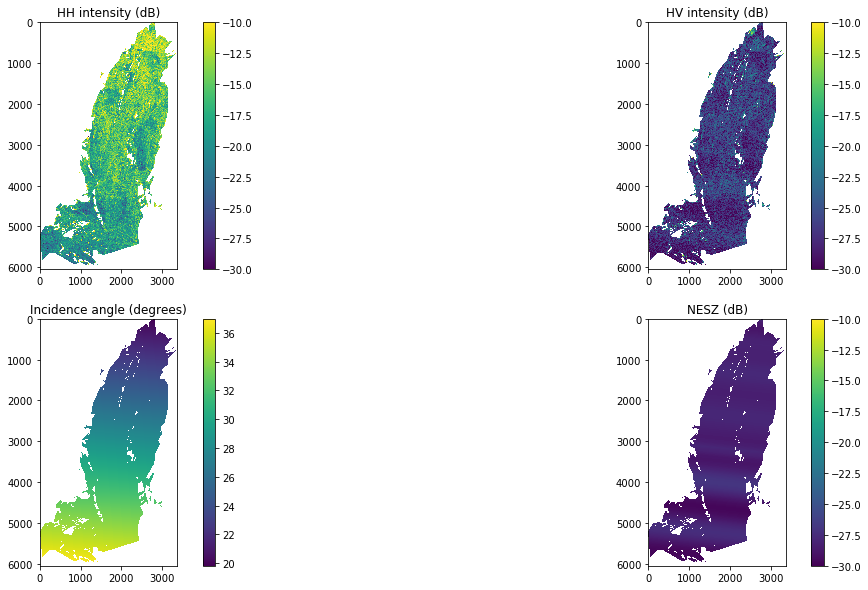

In [22]:
fig, ax = plt.subplots(2,2,figsize=(20,10))

hh_plot = ax[0,0].imshow(hh, vmin=-30, vmax=-10)
ax[0,0].set_title('HH intensity (dB)')
fig.colorbar(hh_plot, ax=ax[0,0])
hv_plot = ax[0,1].imshow(hv, vmin=-30, vmax=-10)
ax[0,1].set_title('HV intensity (dB)')
fig.colorbar(hv_plot, ax=ax[0,1])
ang_plot = ax[1,0].imshow(ang)
ax[1,0].set_title('Incidence angle (degrees)')
fig.colorbar(ang_plot, ax=ax[1,0])
noise_plot = ax[1,1].imshow(noise, vmin=-30, vmax=-10)
ax[1,1].set_title('NESZ (dB)')
fig.colorbar(noise_plot, ax=ax[1,1])